In [1]:
# import packages
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
from datetime import datetime
import seaborn as sns
import pickle
sns.set_style("whitegrid")

In [ ]:
# read in review and movie data into data frames
dfb = pd.read_csv('./cleandata/rotten_tomatoes_movie_reviews_clean_binary.csv', index_col=False)   
dfs = pd.read_csv('./cleandata/rotten_tomatoes_movie_reviews_clean_scale.csv', index_col=False)
dfm = pd.read_csv('./cleandata/rotten_tomatoes_movies_clean.csv', index_col=False)

dfm.head(10)

                         id                     title  audienceScore  \
0               adrift_2018                    Adrift           65.0   
1      1035316-born_to_kill              Born to Kill           74.0   
2      margarita_happy_hour      Margarita Happy Hour            NaN   
3               1221483-paa                       Paa           67.0   
4    sarah_palin_you_betcha  Sarah Palin: You Betcha!           61.0   
5      a_state_of_mind_2005           A State of Mind           92.0   
6  tripping_with_nils_frahm  Tripping with Nils Frahm            NaN   
7                haunted_3d                   Haunted           74.0   
8              gun_shy_2017                     Salty           38.0   
9               johnny_cool               Johnny Cool           44.0   

   tomatoMeter rating                                     ratingContents  \
0         69.0  PG-13  ['Injury Images', 'Brief Drug Use', 'Thematic ...   
1         83.0    NaN                                  

In [ ]:
dfr = dfm.filter(['id', 'title', 'releaseDateTheaters']) # One line per movie with id, title, and "Release Date"
dfw = dfs.filter(['id', 'creationDate', 'isTopCritic', 'originalScore']) # One line per review with normalized score, etc.
dfw['binaryScore'] = [0 if sS == "NEGATIVE" else 1 for sS in dfs['scoreSentiment']] # Convert sentiment to numerical value

movie_ids_winfo = pd.unique(dfr['id']).tolist() # unique list of movie ids

mask = dfw['id'].isin(movie_ids_winfo)
dfw = dfw[mask]

cutoff_week = 2

dfw = dfw.merge(dfr[['id', 'releaseDateTheaters']], on='id', how='inner')
dfw['releaseDateTheaters'] = pd.to_datetime(dfw['releaseDateTheaters'])
dfw['creationDate'] = pd.to_datetime(dfw['creationDate'])
dfw['reviewWeek'] = (dfw['creationDate']-dfw['releaseDateTheaters']).dt.days
dfw['reviewWeek'] = [math.floor(d/7) for d in dfw['reviewWeek']]

dfw_chopped = dfw[dfw['reviewWeek']<2]

movie_ids_wrevs = pd.unique(dfw_chopped['id']).tolist()
mask2 = dfr['id'].isin(movie_ids_wrevs)
dfr = dfr[mask2]

movie_ids_winfo = pd.unique(dfr['id']).tolist()

print(len(movie_ids_wrevs))
print(len(dfr))
print(len(movie_ids_winfo))

dfr = dfr.sort_values('id')
dfw_chopped = dfw_chopped.sort_values('id')

# dfr.head(10)
dfw_chopped.head()

13588
13588
13588


,id,creationDate,isTopCritic,originalScore,binaryScore,releaseDateTheaters,reviewWeek
571619,10000390-mickey,2004-05-06,True,0.750,1,2004-04-30,0
571620,10000390-mickey,2004-05-06,True,0.575,0,2004-04-30,0
387380,10000_bc,2008-03-06,False,0.400,0,2008-03-07,-1
387326,10000_bc,2008-03-09,False,0.175,0,2008-03-07,0
387327,10000_bc,2008-03-08,True,0.250,0,2008-03-07,0
387328,10000_bc,2008-03-08,False,0.500,0,2008-03-07,0
387329,10000_bc,2008-03-08,False,0.250,0,2008-03-07,0
387330,10000_bc,2008-03-07,False,0.500,0,2008-03-07,0
387331,10000_bc,2008-03-07,False,0.625,1,2008-03-07,0
387325,10000_bc,2008-03-09,False,0.200,0,2008-03-07,0


Our next task is to get the "opening" cutoff week for each movie based on the threshold from the box office data

In [4]:
rawNewBoxOffice = pd.read_csv("./cleandata/1977-2025_clean.txt", sep='\t')
rawNewBoxOffice = rawNewBoxOffice.rename(columns={'Gross ($)': 'Weekly', 'Theater Number': 'Theaters'})
newBoxOffice ={}
for rawMovieTitle in rawNewBoxOffice['Movie Title'].unique():
    movieTitle = "-".join(rawMovieTitle.split('-')[:-1])
    newBoxOffice[movieTitle] = rawNewBoxOffice[rawNewBoxOffice['Movie Title'] == rawMovieTitle]
    dates = list(newBoxOffice[movieTitle].Date)
    # print(dates)
    xdata = [1]
    # Producing a "Week Column for movie data"
    for j in range(1,len(dates)):
        xdata += [int((datetime.strptime(dates[j],'%Y-%m-%d')-datetime.strptime(dates[j-1],'%Y-%m-%d')).days/7)+xdata[j-1]]
    # newBoxOffice[movieTitle]['Week'] = xdata
    newBoxOffice[movieTitle].insert(1, "Week", xdata)
    newBoxOffice[movieTitle].insert(5, "Avg", newBoxOffice[movieTitle]['Weekly']/newBoxOffice[movieTitle]['Theaters'])
    newBoxOffice[movieTitle] = newBoxOffice[movieTitle].set_index('Week')
    newBoxOffice[movieTitle].insert(1, "Week", xdata)

boxOffice = newBoxOffice
titles = list(boxOffice.keys())
stringVal = False
badOrder = 0
for title in titles:
    movieData = boxOffice[title]
    # Remove entries with no weekly gross data, number of theaters, or with fewer than three reported weeks
    if ('Weekly' not in movieData.columns) or ('-' in movieData.Theaters.values) or (True in pd.isna(movieData.Theaters.values)) or (int(max(movieData.Week))<=3) or (movieData.Week.iloc[0]!=1):
        del boxOffice[title]
    # A few movies have special opening weekends which open very small. I've excluded them
    elif (type(movieData.Week.values[0])==str):
        print(title)
        del boxOffice[title]

pickle.dump( boxOffice, open( "CleanedBoxofficeData.p", "wb" ) )

Text(0.5, 0.98, 'Multiplier distribution for openings of various relative widths')

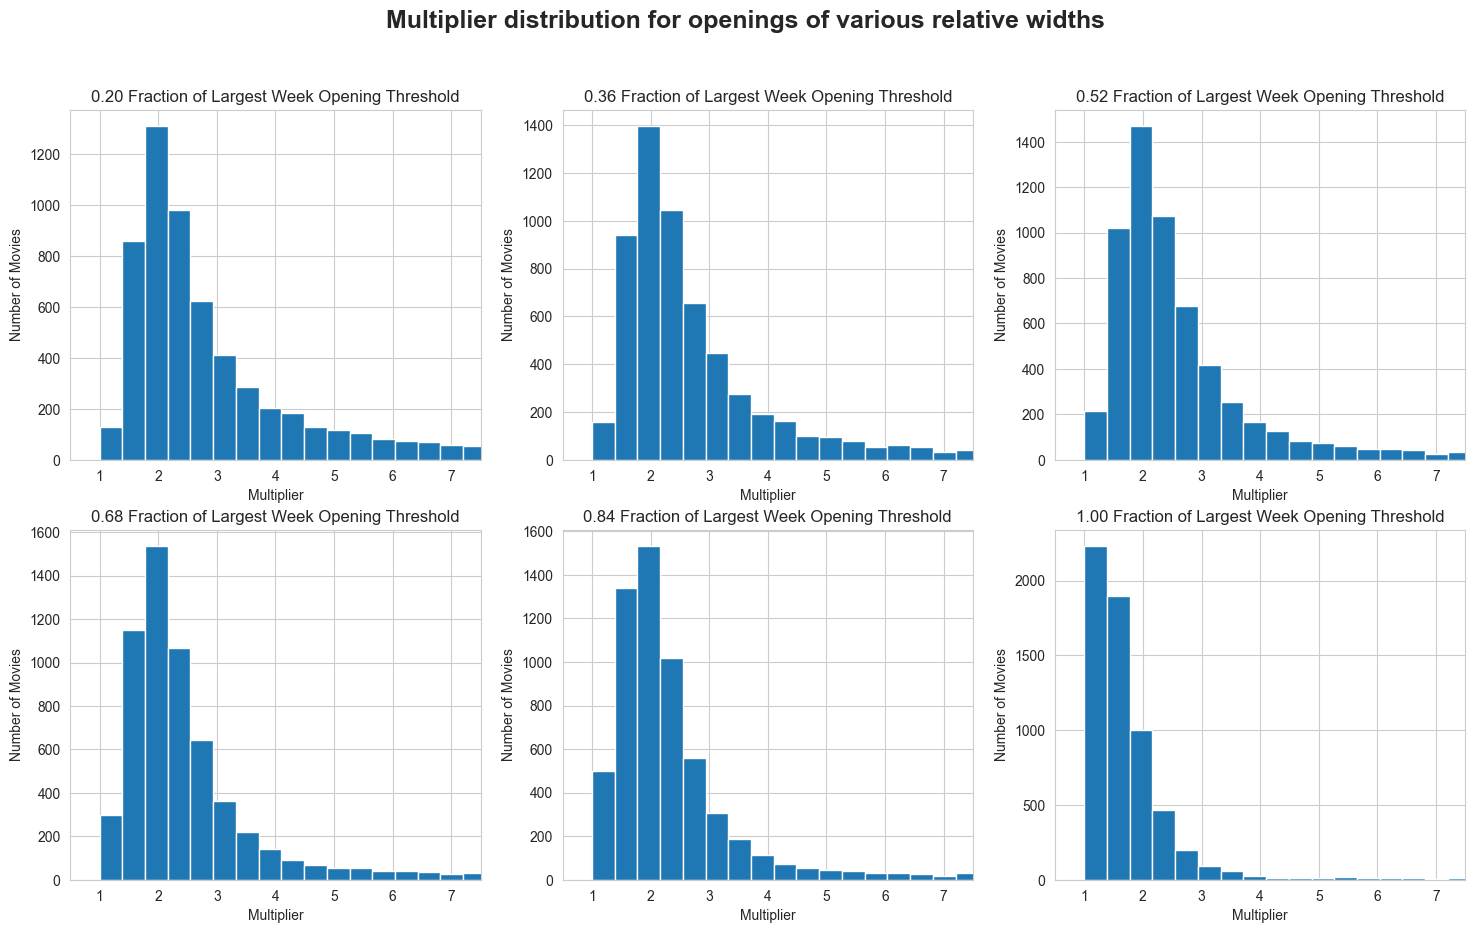

In [8]:
fig, axs = plt.subplots(2, 3, figsize=(18,10))
i=0
for threshold in np.linspace(0.2, 1, 6):
    smartMultipliers = {}
    for title in boxOffice:
        widestWeek = max(boxOffice[title].Theaters)
        startingWeek = 0
        currentWeek = 0
        for week in boxOffice[title].Theaters>=threshold*widestWeek:
            currentWeek+=1
            if week:
                startingWeek = currentWeek
                break
        opening = sum(boxOffice[title].Weekly.iloc[0:startingWeek].values)
        total = sum(boxOffice[title].Weekly.values)
        multiplier = total/opening
        smartMultipliers[title] = multiplier
    axs[i//3, i%3].hist(smartMultipliers.values(), bins=np.linspace(1, 20, 50))
    axs[i//3, i%3].set_xlim([0.5, 7.5])
    axs[i//3, i%3].set_title('%.2f Fraction of Largest Week Opening Threshold' %threshold)
    axs[i//3, i%3].set_xlabel("Multiplier")
    axs[i//3, i%3].set_ylabel("Number of Movies")
    # axs[i//3, i%3].set_yscale('log')
    i+=1
fig.suptitle("Multiplier distribution for openings of various relative widths", fontsize=18, fontweight="bold")

In [7]:
boxOffice['102 Dalmatians (2000)'].head()

,Movie Title,Week,Rank,Weekly,Theaters,Avg,Change in Theater Number,Gross to Date,Date
Week,,,,,,,,,
1,102 Dalmatians (2000)-rl927041025,1,11,6352745,2704.0,2349.387944,NaN,6352745.0,2000-11-17
2,102 Dalmatians (2000)-rl927041025,2,3,21955572,2704.0,8119.664201,NaN,28308317.0,2000-11-24
3,102 Dalmatians (2000)-rl927041025,3,3,9738329,2704.0,3601.453033,NaN,38046646.0,2000-12-01
4,102 Dalmatians (2000)-rl927041025,4,6,7284225,2704.0,2693.870192,NaN,45330871.0,2000-12-08
5,102 Dalmatians (2000)-rl927041025,5,8,4247658,2190.0,1939.569863,-514.0,49578529.0,2000-12-15


In [6]:
dfw_chopped[dfw_chopped['id']=='10000_bc']

,id,creationDate,isTopCritic,originalScore,binaryScore,releaseDateTheaters,reviewWeek
387380,10000_bc,2008-03-06,False,0.400,0,2008-03-07,-1
387326,10000_bc,2008-03-09,False,0.175,0,2008-03-07,0
387327,10000_bc,2008-03-08,True,0.250,0,2008-03-07,0
387328,10000_bc,2008-03-08,False,0.500,0,2008-03-07,0
387329,10000_bc,2008-03-08,False,0.250,0,2008-03-07,0
...,...,...,...,...,...,...,...
387302,10000_bc,2008-03-16,False,0.600,1,2008-03-07,1
387303,10000_bc,2008-03-16,False,0.375,0,2008-03-07,1
387301,10000_bc,2008-03-17,False,0.250,0,2008-03-07,1
387300,10000_bc,2008-03-18,False,0.250,0,2008-03-07,1
